In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
CLASSES = ['Angle', 'Box', 'Circle', 'Closeup', 'Crowd', 'Other']

transform = transforms.Compose([transforms.Resize((720, 1280)), transforms.ToTensor()])
training_dataset = torchvision.datasets.ImageFolder(root='./train/', transform=transform)
training_loader = DataLoader(training_dataset, batch_size=len(training_dataset), num_workers=0)


In [4]:
# Calculate the mean and std
dataiter = iter(training_loader)
images, _ = dataiter.next()
imgs = images.view(images.size(0), images.size(1), -1)
mean = imgs.mean(2).sum(0) / imgs.size(0)
std = imgs.std(2).sum(0) / imgs.size(0)
print(f"The mean is: {mean}")
print(f"The std is: {std}")

The mean is: tensor([0.3827, 0.4044, 0.3235])
The std is: tensor([0.1845, 0.1861, 0.1851])


In [10]:
# mean std
mean = torch.tensor([0.3827, 0.4044, 0.3235])
std = torch.tensor([0.1845, 0.1861, 0.1851])

normalized_transform = transforms.Compose([
    transforms.Resize([720, 1280]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

batch_size = 1
normalized_training_dataset = torchvision.datasets.ImageFolder(root='./train/', transform=normalized_transform)
normalized_testing_dataset = torchvision.datasets.ImageFolder(root='./test/', transform=normalized_transform)
normalized_training_loader = DataLoader(normalized_training_dataset, batch_size=batch_size, shuffle=True)
normalized_testing_loader = DataLoader(normalized_testing_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


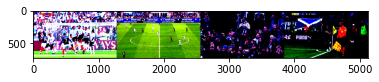

In [34]:
# Data Visulazation

normalized_training_dataiter = iter(normalized_training_loader)
images, labels = normalized_training_dataiter.next()

normalized_images_grid = torchvision.utils.make_grid(images)
np_images_grid = normalized_images_grid.numpy()
plt.imshow(np.transpose(np_images_grid, (1 ,2, 0)))

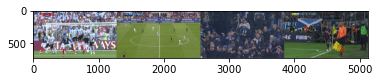

In [38]:
un_normalized_images = normalized_images_grid * std[:, None, None] + mean[:, None, None]
np_un_images_grid = un_normalized_images.numpy()
plt.imshow(np.transpose(np_un_images_grid, (1 ,2, 0)))

In [4]:
from mobilenet_v2 import MobileNetV2

model = MobileNetV2(num_classes=len(CLASSES))
model.cuda()
print(model)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(normalized_training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs.cuda())
        
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.cuda())
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        
        # Gather data and report
        running_loss += loss.item()
        if i % 5 == 4:
            last_loss = running_loss / 5 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        inputs.detach()
        labels.detach()
        outputs.detach()
            
    return last_loss

In [2]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

ModuleNotFoundError: No module named 'tensorboard'

In [1]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/soccer_trainer_{}'.format(timestamp))
epoch_number = 0

NameError: name 'datetime' is not defined

In [13]:
EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    # We don't need gradients on to do reporting
    model.train(False)
    
    running_vloss = 0.0
    for i, vdata in enumerate(normalized_testing_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs.cuda())
        vloss = loss_fn(voutputs, vlabels.cuda())
        running_vloss += vloss
        vinputs.detach()
        vlabels.detach()
        
    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    epoch_number += 1

EPOCH 1:
  batch 5 loss: 1.8625285148620605
  batch 10 loss: 2.085236668586731
  batch 15 loss: 1.806067419052124
  batch 20 loss: 1.784613585472107
  batch 25 loss: 1.9845398902893066
  batch 30 loss: 1.8257354497909546
  batch 35 loss: 2.094508445262909
  batch 40 loss: 1.693385934829712
  batch 45 loss: 2.27831130027771
  batch 50 loss: 2.778684604167938
  batch 55 loss: 1.6590397000312804
  batch 60 loss: 3.318523645401001
  batch 65 loss: 2.3756311416625975
  batch 70 loss: 1.7285244345664978
  batch 75 loss: 2.1848403096199034
  batch 80 loss: 1.5190455794334412
  batch 85 loss: 1.9973205924034119
  batch 90 loss: 1.8901106595993042
  batch 95 loss: 2.121627688407898
  batch 100 loss: 1.8464898824691773
  batch 105 loss: 2.4970243692398073
  batch 110 loss: 1.8890148878097535
  batch 115 loss: 1.4191055178642273
  batch 120 loss: 2.7958279609680177
  batch 125 loss: 2.690362012386322
  batch 130 loss: 2.2154505491256713
  batch 135 loss: 1.6060320615768433
  batch 140 loss: 1.348

RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 8.00 GiB total capacity; 7.14 GiB already allocated; 0 bytes free; 7.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF